In [1]:
# import libraries

import numpy as np
from collections import defaultdict

from Bio import SeqIO
from Bio.SeqUtils import ProtParamData
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import IsoelectricPoint

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import pyplot
import itertools
from itertools import cycle
from scipy import interp

import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_val_predict, GridSearchCV

In [2]:
label_encoder = LabelEncoder()
vectorizer = DictVectorizer()

In [3]:
# create the lists and dictionaries needed to "hold" the data
class_names = ["Cytosolic", "Mitochondrial", "Nuclear", "Secreted"]
labels = []
mito_list = []
cyto_list = []
nucleus_list = []
secreted_list = []
blind_list = []
mito_count_dict = defaultdict(float)
cyto_count_dict = defaultdict(float)
nucleus_count_dict = defaultdict(float)
secreted_count_dict = defaultdict(float)
full_dict = defaultdict(float)

In [4]:
# create a list for every class and then a list that contains every class
for seq_record in SeqIO.parse("cyto.fasta.txt", "fasta"):
    cyto_list.append(str(seq_record.seq))
    labels.append("Cytosolic")
    
for seq_record in SeqIO.parse("mito.fasta.txt", "fasta"):
    mito_list.append(str(seq_record.seq))
    labels.append("Mitochondrial")
    
for seq_record in SeqIO.parse("nucleus.fasta.txt", "fasta"):
    nucleus_list.append(str(seq_record.seq))
    labels.append("Nuclear")
    
for seq_record in SeqIO.parse("secreted.fasta.txt", "fasta"):
    secreted_list.append(str(seq_record.seq))
    labels.append("Secreted")

for seq_record in SeqIO.parse("blind.fasta.txt", "fasta"):
    blind_list.append(str(seq_record.seq))

full_list = cyto_list + mito_list + nucleus_list + secreted_list

In [5]:
# get the dataset statistics
lengths_list = []
mito_lengths = []
cyto_lengths = []
nucleus_lengths = []
secreted_lengths = []
list_of_lists = []
stats_dict = {}
for sequence in full_list:
    lengths_list.append(len(sequence))
for sequence in cyto_list:
    cyto_lengths.append(len(sequence))
for sequence in mito_list:
    mito_lengths.append(len(sequence))
for sequence in nucleus_list:
    nucleus_lengths.append(len(sequence))
for sequence in secreted_list:
    secreted_lengths.append(len(sequence))

list_of_lists.append(cyto_lengths)
list_of_lists.append(mito_lengths)  
list_of_lists.append(nucleus_lengths)
list_of_lists.append(secreted_lengths)

for i, category in enumerate(class_names):
    stats_dict[str(category)] = [len(list_of_lists[i]),np.mean(list_of_lists[i]), np.std(list_of_lists[i]),
                                 np.min(list_of_lists[i]), np.max(list_of_lists[i])]

In [6]:
# preprocessing step
full_count_dict = defaultdict(float)
replaced_count_dict = defaultdict(float)
analysed_list = []

for sequence in full_list:
    for aminoacid in sequence:
        full_count_dict[aminoacid] += 1.0

for i in range(len(full_list)):
    full_list[i] = full_list[i].replace("X", "")
    full_list[i] = full_list[i].replace("U", "")
    full_list[i] = full_list[i].replace("B", "N")
    
for sequence in full_list:
    analysed_list.append(ProteinAnalysis(sequence))
    for aminoacid in sequence:
        replaced_count_dict[aminoacid] += 1.0

In [7]:
# define a function that extracts features from a sequence of aminoacids
# originally from http://biopython.org/
def molar_extinction_coefficient(proteinobject):
    """
    Calculate the molar extinction coefficient.
    Calculates the molar extinction coefficient assuming cysteines
    (reduced) and cystines residues (Cys-Cys-bond)
    """
    num_aa = proteinobject.count_amino_acids()
    mec_reduced = num_aa['W'] * 5500 + num_aa['Y'] * 1490
    mec_cystines = mec_reduced + (num_aa['C'] // 2) * 125
    
    return(mec_reduced, mec_cystines)

def feature_extractor(sequence):
    """
    Create a dictionary of features derived from the amino acid chain
    for each sequence. They names of the dictionary keys are representative
    of the features.
    """
    analysed_sequence = ProteinAnalysis(sequence)
    
    sequence_dict = defaultdict(float)
    
    
    for aminoacid1 in replaced_count_dict.keys():
        for aminoacid2 in replaced_count_dict.keys():       
            sequence_dict[str(aminoacid1)+str(aminoacid2)] = 0.0
    for aminoacid1 in replaced_count_dict.keys():
        for aminoacid2 in replaced_count_dict.keys(): 
            for i in range(len(sequence)-1):
                if (str(sequence[i]) + str(sequence[i+1]) == str(aminoacid1) + str(aminoacid2)):
                    sequence_dict[str(sequence[i])+str(sequence[i+1])] +=1.0
                
    for aminoacid1 in replaced_count_dict.keys():
        for aminoacid2 in replaced_count_dict.keys(): 
            sequence_dict[str(aminoacid1)+str(aminoacid2)] = sequence_dict[str(aminoacid1)+str(aminoacid2)]/len(sequence)
    
    for aminoacid in replaced_count_dict.keys():
        sequence_dict[str(aminoacid) + "_%"] = sequence.count(aminoacid)/len(sequence)
        sequence_dict[str(aminoacid) + "_%"+"_F50"] = sequence[:50].count(aminoacid)/len(sequence[:50])       
        sequence_dict[str(aminoacid) + "_%"+"_L50"] = sequence[-50:].count(aminoacid)/len(sequence[-50:])                                
    sequence_dict["aromaticity"] = analysed_sequence.aromaticity() 
    
    sequence_dict["instability_index"] = analysed_sequence.instability_index()
    
    sequence_dict["gravy"] = analysed_sequence.gravy()
    
    sequence_dict["isoelectric_point"] = analysed_sequence.isoelectric_point()
    
    sequence_dict["helix"] = analysed_sequence.secondary_structure_fraction()[0]

    sequence_dict["turn"] = analysed_sequence.secondary_structure_fraction()[1]
      
    sequence_dict["sheet"] = analysed_sequence.secondary_structure_fraction()[2]

    sequence_dict["length"] = len(sequence)
    
    sequence_dict["molar_ex_coef1"] = molar_extinction_coefficient(analysed_sequence)[0]
    
    sequence_dict["molar_ex_coef2"] = molar_extinction_coefficient(analysed_sequence)[1]
    
    sequence_dict["hydrophobic_%"] = (sequence.count('A') + sequence.count('I') + sequence.count('L') +
                                       sequence.count('M') + sequence.count('P') + sequence.count('F') +
                                       sequence.count('W') + sequence.count('V')) / len(sequence)    

    sequence_dict['pos_charged_%'] = (sequence.count('H') + sequence.count('K') +
                                           sequence.count('R')) / len(sequence)

    sequence_dict['neg_charged_%']  =  (sequence.count('D') + sequence.count('E')) / len(sequence)

    sequence_dict['polar_%']  =  (sequence.count('R') + sequence.count('N') + sequence.count('D') +
                                sequence.count('E') + sequence.count('Q') + sequence.count('H') +
                                sequence.count('K') + sequence.count('S') + sequence.count('T') +  
                                sequence.count('Y')) / len(sequence)

    sequence_dict['acidic_%']  =  (sequence.count('D') + sequence.count('E')) / len(sequence) 

    sequence_dict['basic_%']  =  (sequence.count('R') + sequence.count('H') + sequence.count('K')) / len(sequence) 
                                 
    point_0 = IsoelectricPoint.IsoelectricPoint(analysed_sequence, analysed_sequence.count_amino_acids())
    point = point_0._select_charged(analysed_sequence.count_amino_acids())
    
    sequence_dict["isoelectric_c"] = point["C"]
    sequence_dict["isoelectric_Cterm"] = point["Cterm"]
    sequence_dict["isoelectric_d"] = point["D"]
    sequence_dict["isoelectric_e"] = point["E"]
    sequence_dict["isoelectric_h"] = point["H"]
    sequence_dict["isoelectric_k"] = point["K"]
    sequence_dict["isoelectric_Nterm"] = point["Nterm"]
    sequence_dict["isoelectric_r"] = point["R"]
    sequence_dict["isoelectric_y"] = point["Y"]

    sequence_dict["hydrophobic_%_F50"] = (sequence[:50].count('A') + sequence[:50].count('I') + sequence[:50].count('L') +
                                       sequence[:50].count('M') + sequence[:50].count('P') + sequence[:50].count('F') +
                                       sequence[:50].count('W') + sequence[:50].count('V')) / len(sequence[:50])    
 
    sequence_dict['pos_charged_%_F50'] = (sequence[:50].count('H') + sequence[:50].count('K') +
                                           sequence[:50].count('R')) / len(sequence[:50])

    sequence_dict['neg_charged_%_F50']  =  (sequence[:50].count('D') + sequence[:50].count('E')) / len(sequence[:50])
 
    sequence_dict['polar_F50']  =  (sequence[:50].count('R') + sequence[:50].count('N') + sequence[:50].count('D') +
                                sequence[:50].count('E') + sequence[:50].count('Q') + sequence[:50].count('H') +
                                sequence[:50].count('K') + sequence[:50].count('S') + sequence[:50].count('T') +  
                                sequence[:50].count('Y')) / len(sequence[:50])

    sequence_dict['acidic_F50']  =  (sequence[:50].count('D') + sequence[:50].count('E')) / len(sequence[:50]) 

    sequence_dict['basic_F50']  =  (sequence[:50].count('R') + sequence[:50].count('H')
                                    + sequence[:50].count('K')) / len(sequence[:50])                                 

    sequence_dict["hydrophobic_%_L50"] = (sequence[-50:].count('A') + sequence[-50:].count('I') + sequence[-50:].count('L') +
                                       sequence[-50:].count('M') + sequence[-50:].count('P') + sequence[-50:].count('F') +
                                       sequence[-50:].count('W') + sequence[-50:].count('V')) / len(sequence[-50:])    

    sequence_dict['pos_charged_%_L50'] = (sequence[-50:].count('H') + sequence[-50:].count('K') +
                                           sequence[-50:].count('R')) / len(sequence[-50:])

    sequence_dict['neg_charged_%_L50']  =  (sequence[-50:].count('D') + sequence[-50:].count('E')) / len(sequence[-50:])
  
    sequence_dict['polar_%_L50']  =  (sequence[-50:].count('R') + sequence[-50:].count('N') + sequence[-50:].count('D') +
                                sequence[-50:].count('E') + sequence[-50:].count('Q') + sequence[-50:].count('H') +
                                sequence[-50:].count('K') + sequence[-50:].count('S') + sequence[-50:].count('T') +  
                                sequence[-50:].count('Y')) / len(sequence[-50:])

    sequence_dict['acidic_%_L50']  =  (sequence[-50:].count('D') + sequence[-50:].count('E')) / len(sequence[-50:]) 

    sequence_dict['basic_%_L50']  =  (sequence[-50:].count('R') + sequence[-50:].count('H')
                                    + sequence[-50:].count('K')) / len(sequence[-50:])     
    return sequence_dict


def predict(sequence_list, model):
    """
    define a function that predicts the class of a new sequence
    """
    x_test = vectorizer.transform([feature_extractor(x) for x in sequence_list])
    predictions = label_encoder.inverse_transform(model.predict(x_test))
    probabilities = model.predict_proba(x_test)
    
    return predictions, probabilities

# define a function that computes and plots a confusion matrix (normilized or not)
# code originally from http://scikit-learn.org/
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
# transform the sequences into numerical features usable by a classifier
x_data = vectorizer.fit_transform([feature_extractor(x) for x in full_list]).toarray()
# transform the labels into numerical values usable by a classifier
y_data = label_encoder.fit_transform([y for y in labels])

# split the dataset into train and test using stratified sampling
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1,
                                                    random_state=13, stratify=y_data)

In [9]:
#dataset statistics for each class after the split (overall-train-test)
unique, counts = np.unique(y_data, return_counts=True)
data_distr = dict(zip(unique, counts/y_data.shape[0]))
unique, counts = np.unique(y_test, return_counts=True)
test_distr = dict(zip(unique, counts/y_test.shape[0]))
unique, counts = np.unique(y_train, return_counts=True)
train_distr = dict(zip(unique, counts/y_train.shape[0]))
unique, counts = np.unique(y_test, return_counts=True)
test_distr = dict(zip(unique, counts/y_test.shape[0]))
print(y_data.shape[0])
print(data_distr)
print(y_train.shape[0])
print(train_distr)
print(y_test.shape[0])
print(test_distr)

9222
{0: 0.32574278898286707, 1: 0.14085881587508134, 2: 0.35935805682064625, 3: 0.17404033832140534}
8299
{0: 0.32570189179419207, 1: 0.14086034461983371, 2: 0.3593204000481986, 3: 0.17411736353777563}
923
{0: 0.32611050920910079, 1: 0.14084507042253522, 2: 0.35969664138678226, 3: 0.1733477789815818}


In [10]:
# if tuning==True perform a grid search over 125 models using 10fold for each model
# Warning: This might take a couple of days to complete
tuning = False
if tuning:
    model = xgboost.XGBClassifier()
    n_estimators = [200, 400, 500, 700, 1000]
    max_depth = [7, 10, 12, 15, 20]
    gamma = [i/10.0 for i in range (0,5)]
    param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, gamma=gamma)
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(x_train, y_train)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [11]:
# if cross_validation == True a 10 fold-cross validation is performed for a given model
# and accurcaies are reported over the 10 folds
cross_validation = False
if cross_validation:
    model = xgboost.XGBClassifier(n_estimators=1000, max_depth=10, n_jobs=-1)
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    accuracies = cross_val_score(model, x_train, y_train, cv=kfold, n_jobs=-1)
    #predictions = cross_val_predict(model, x_train, y_train, cv=kfold, n_jobs=-1)
    print(accuracies)
    print(np.mean(accuracies))
    print(np.std(accuracies))

In [12]:
# use the tuned parameters to train the model and do a final evaluation on the unseen test data
model = xgboost.XGBClassifier(n_estimators=1000, max_depth=10, n_jobs=-1)
model.fit(x_train, y_train)
accuracy = model.score(x_test, y_test)
predictions = model.predict(x_test)
probabilities = model.predict_proba(x_test)
weighted_f1score = f1_score(y_test, predictions, average="weighted")
individual_f1scores = f1_score(y_test, predictions, average=None)
print(accuracy)
print(weighted_f1score)
print(individual_f1scores)

0.710725893824
0.713180860382
[ 0.653125    0.71485944  0.70534351  0.8410596 ]


In [14]:
# find the important features using build-in method .feature_importances
feature_names_list = vectorizer.get_feature_names()
feature_names = np.array(feature_names_list)
feature_importance_list = model.feature_importances_
feature_importances = np.array(feature_importance_list)
index = feature_importances.argsort()
sorted_names = feature_names[index]
sorted_importances = feature_importances[index]

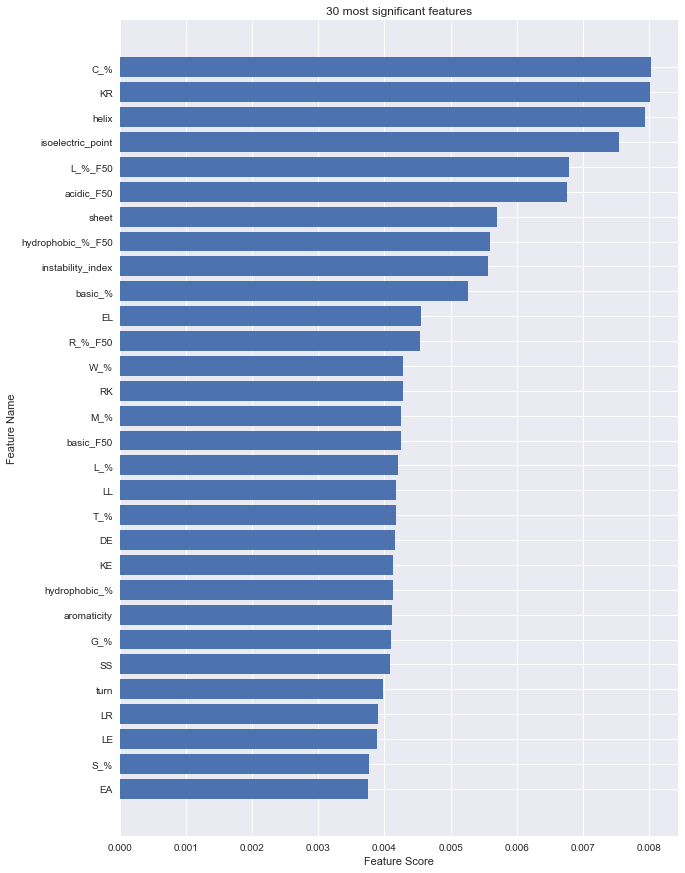

497


In [15]:
#plot the 30 most significant features
fig, ax = plt.subplots(figsize=(10, 15))
y_pos = np.arange(len(sorted_names[-30:]))
ax.barh(y_pos, sorted_importances[-30:])
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_names[-30:])
ax.set_xlabel("Feature Score")
ax.set_ylabel('Feature Name')
ax.set_title("30 most significant features")
pyplot.show()
print(len(feature_names))

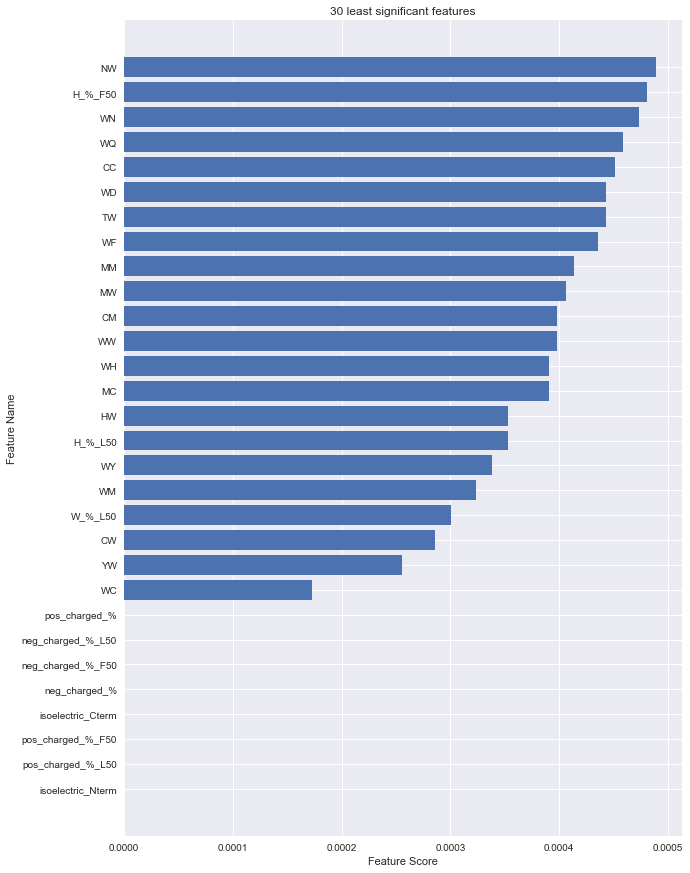

In [17]:
# plot the 30 least significant features
fig, ax = plt.subplots(figsize=(10, 15))
y_pos = np.arange(len(sorted_names[:30]))
ax.barh(y_pos, sorted_importances[:30])
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_names[:30])
ax.set_xlabel('Feature Score')
ax.set_ylabel('Feature Name')
ax.set_title('30 least significant features')
pyplot.show()

Confusion matrix, without normalization
[[209  19  66   7]
 [ 22  89  17   2]
 [ 91   4 231   6]
 [ 17   7   9 127]]
Normalized confusion matrix
[[ 0.69  0.06  0.22  0.02]
 [ 0.17  0.68  0.13  0.02]
 [ 0.27  0.01  0.7   0.02]
 [ 0.11  0.04  0.06  0.79]]


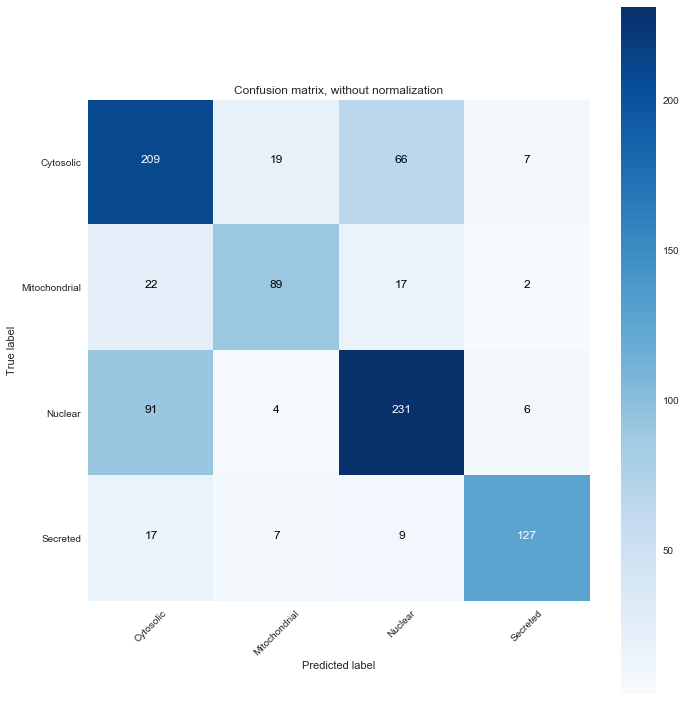

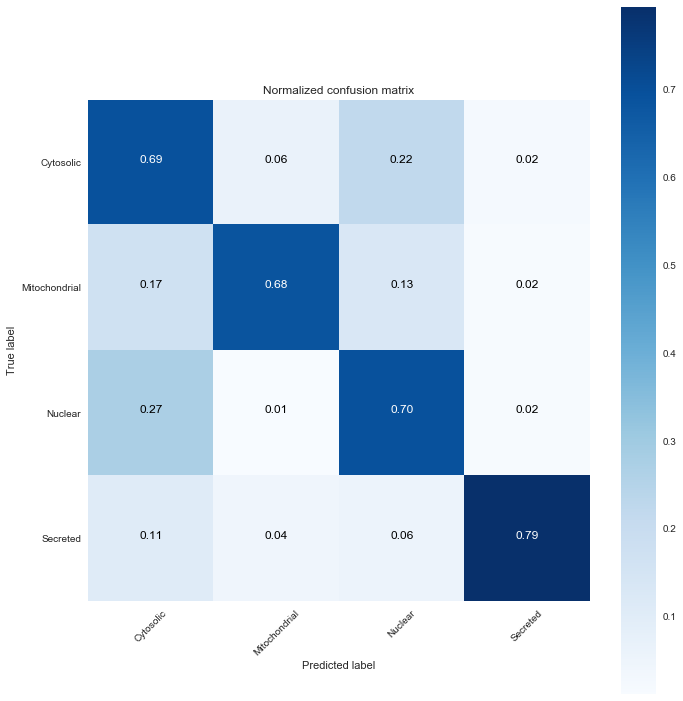

In [16]:
# plot the confusion matrices
sns.set_style("dark")
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                  title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                  title='Normalized confusion matrix')

plt.show()

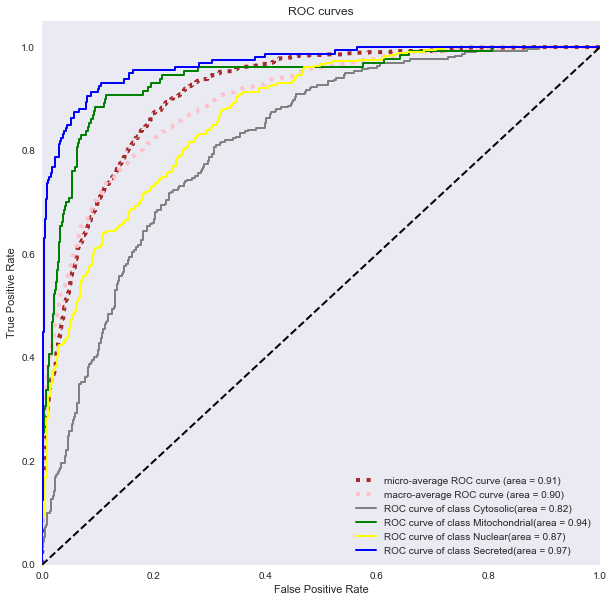

In [17]:
# Binarize the output
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = 4
# Learn to predict each class against the other
classifier = OneVsRestClassifier(xgboost.XGBClassifier(n_estimators=1000, max_depth=10, n_jobs=-1))
y_score = classifier.fit(x_train, y_train_binarized).predict_proba(x_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
my_roc = dict()
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    my_roc[i] = roc_auc_score(y_test_binarized[:, i], y_score[:, i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='brown', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='pink', linestyle=':', linewidth=4)

colors = cycle(['grey', 'green', 'yellow', 'blue'])
for category, color,i in zip(class_names, colors, range(n_classes)):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=('ROC curve of class ' + str(category) + '(area = {1:0.2f})').format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()

In [18]:
# print auc scores
print(roc_auc)

{0: 0.81618079071903959, 1: 0.93873314579493661, 2: 0.87055327910627278, 3: 0.96830766710353866, 'micro': 0.91243929951909142, 'macro': 0.89905271097853945}


In [19]:
#train the final model using all data available (training+test)
final_model = xgboost.XGBClassifier(n_estimators=1000, max_depth=10, n_jobs=-1)
final_model.fit(x_data, y_data)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
# predict the labels of the unlabeled set and get the confidence scores and print them out
blind_predictions, blind_probabilities = predict(blind_list, final_model)
print(blind_predictions)
print(blind_probabilities)

['Cytosolic' 'Secreted' 'Mitochondrial' 'Nuclear' 'Nuclear' 'Nuclear'
 'Cytosolic' 'Cytosolic' 'Cytosolic' 'Mitochondrial' 'Mitochondrial'
 'Mitochondrial' 'Secreted' 'Secreted' 'Nuclear' 'Nuclear' 'Cytosolic'
 'Cytosolic' 'Mitochondrial' 'Cytosolic']
[[  6.66e-01   1.47e-03   1.17e-02   3.20e-01]
 [  3.15e-04   1.34e-04   3.57e-05   1.00e+00]
 [  3.77e-02   7.18e-01   8.63e-02   1.58e-01]
 [  9.88e-04   3.47e-05   9.97e-01   1.65e-03]
 [  5.66e-03   2.20e-04   9.93e-01   6.96e-04]
 [  2.04e-03   1.42e-06   9.98e-01   1.11e-06]
 [  5.71e-01   7.62e-02   3.50e-01   3.52e-03]
 [  9.49e-01   3.91e-03   4.74e-02   1.12e-04]
 [  9.71e-01   1.24e-02   1.61e-02   6.54e-05]
 [  1.22e-03   9.98e-01   2.54e-04   4.11e-04]
 [  8.13e-04   9.99e-01   3.96e-04   1.12e-04]
 [  4.23e-04   9.98e-01   1.82e-03   2.78e-05]
 [  2.64e-02   7.54e-03   3.70e-02   9.29e-01]
 [  2.31e-04   1.46e-06   4.69e-05   1.00e+00]
 [  1.88e-04   1.37e-05   1.00e+00   3.38e-05]
 [  2.06e-04   5.83e-05   9.99e-01   4.25e-

In [21]:
# save predictions, confidence scores along with each proteins sequence id in a text file
file = open("blind_predictions.txt","w") 
file.write("Id" + " " + "Prediction" + " " + "Confidence" + "\n")
for seq_record, seq_prediction, seq_confidence in zip(SeqIO.parse("blind.fasta.txt", "fasta"), blind_predictions, blind_probabilities):
    #print(seq_record.id)
    file.write(seq_record.id + " " + seq_prediction + " "+ str(np.max(seq_confidence)) + "\n") 
file.close() 